In [ ]:
import numpy as np
import pandas as pd
import re
import string
from string import punctuation

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import TweetTokenizer   
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


##**Reading Dataset**

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.shape)
print(test_df.shape)

(159571, 8)
(153164, 2)


In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


##**Data Visualization**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


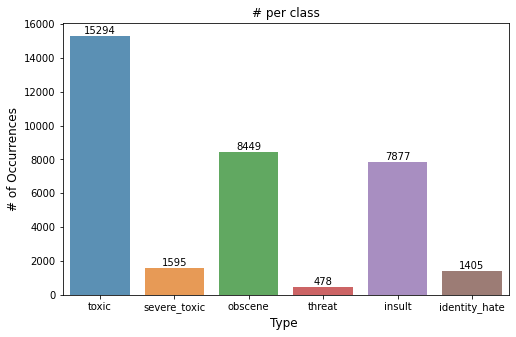

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

x=train_df.iloc[:,2:].sum()

#plot
plt.figure(figsize=(8,5))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5,
            label, ha='center', va='bottom')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


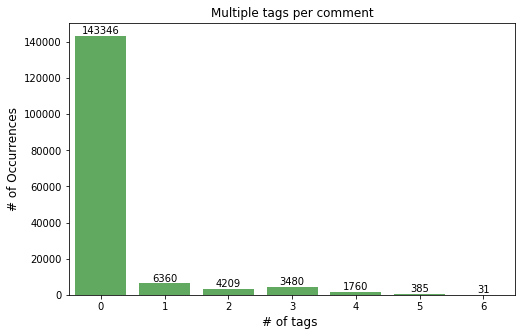

In [ ]:
rowsums=train_df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
color = sns.color_palette()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5,
            label, ha='center', va='bottom')

plt.show()

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values

##**Text Preprocessing**

In [ ]:
def clean_text(text):
    lem = WordNetLemmatizer()
    tokenizer=TweetTokenizer()
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)

    text = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)
    text = re.sub("\W+"," ",text)
    text = re.sub("  "," ",text)

    words = tokenizer.tokenize(text)

    #Lemmatization
    words=[lem.lemmatize(word,"v") for word in words]
    clean_comment = " ".join(words)

    return clean_comment

In [ ]:
train_sentence = train_df['comment_text'].map(lambda x: clean_text(x))
test_sentence = test_df['comment_text'].map(lambda x: clean_text(x))

In [ ]:
m = 0
print("Before preprocessing\n",train_df['comment_text'][m],"\n\n")
print("After preprocessing\n",train_sentence[m])

Before preprocessing
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 


After preprocessing
 explanation why edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since i m retire now


## **Tokenization and Padding**

In [ ]:
max_features = 20000 # how many unique words to use
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_sentence))
tokenized_train = tokenizer.texts_to_sequences(train_sentence)
tokenized_test = tokenizer.texts_to_sequences(test_sentence)

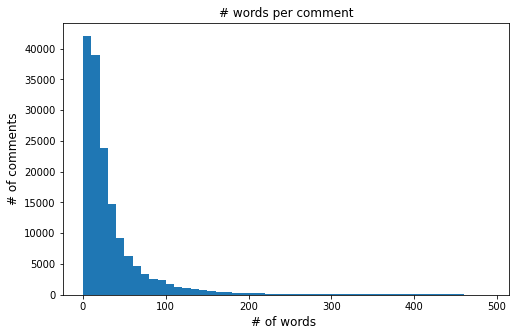

In [ ]:
word_per_comment = [len(comment) for comment in tokenized_train]
plt.figure(figsize=(8,5))
plt.title("# words per comment")
plt.ylabel('# of comments', fontsize=12)
plt.xlabel('# of words ', fontsize=12)
plt.hist(word_per_comment, bins = np.arange(0,500,10))
plt.show()

In [ ]:
maxlen = 200 #max number of words in a comment
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

##**Building Model**

In [ ]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

##**Training Model**

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 166s 37ms/step - loss: 0.0978 - accuracy: 0.8645 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 165s 37ms/step - loss: 0.0461 - accuracy: 0.9868 - val_loss: 0.0515 - val_accuracy: 0.9937


##**Predicting Test Dataset**

In [ ]:
submission = pd.read_csv('sample_submission.csv')
y_pred = model.predict(X_test, batch_size=1024)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('predictions.csv', index=False)

In [ ]:
prediction = pd.read_csv('predictions.csv')
prediction.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996535,3.779812e-01,0.943804,8.593311e-02,0.843445,0.251248
1,0000247867823ef7,0.000563,4.090743e-07,0.000105,2.770272e-06,0.000056,0.000007
2,00013b17ad220c46,0.010103,2.362183e-05,0.001777,1.880097e-04,0.001609,0.000227
3,00017563c3f7919a,0.000219,7.560371e-08,0.000048,3.233533e-07,0.000020,0.000002
4,00017695ad8997eb,0.001622,1.821094e-06,0.000322,1.208726e-05,0.000176,0.000025


In [ ]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

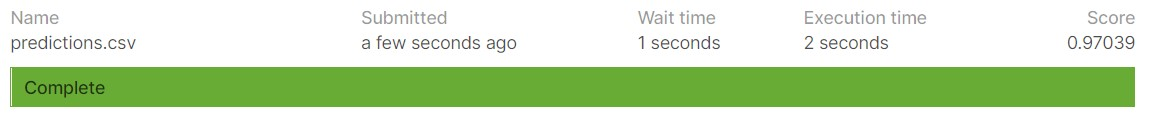

## **Input Comment Prediction**

In [ ]:
user_comment = input("Write your comment: ")
clean_comment = clean_text(user_comment)
tokenized_comment = tokenizer.texts_to_sequences([clean_comment])
user_test_comment = pad_sequences(tokenized_comment, maxlen=maxlen)
user_comment_pred = model.predict(user_test_comment, batch_size=1)

output_df = pd.DataFrame({'Category' : list_classes, 'Predicted Value' : user_comment_pred[0]})
print("\n",output_df.to_string(index=False))    

Write your comment: I hope you die in hell you stupid

       Category  Predicted Value
         toxic         0.988716
  severe_toxic         0.117590
       obscene         0.722164
        threat         0.050195
        insult         0.821286
 identity_hate         0.199138
